In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
import pickle
import json

from pathlib import Path
import numpy as np
from scipy.spatial.distance import euclidean

from utils.extract_openl3_embeddings import EmbeddingsOpenL3
from essentia.standard import MonoLoader, TensorflowPredictEffnetDiscogs, TensorflowPredict2D

import matplotlib.pyplot as plt

from essentia.standard import MonoLoader, TensorflowPredictMusiCNN

import tensorflow as tf
tf.config.run_functions_eagerly(True)

os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
   tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
   print("No GPU found. Please ensure you have installed TensorFlow correctly")
print("Num GPUs:", len(physical_devices))

[   INFO   ] MusicExtractorSVM: no classifier models were configured by default


Num GPUs: 1


I0000 00:00:1728675235.746253   87979 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728675235.749414   87979 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728675235.749630   87979 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [16]:
CLASSES = "utils/msd-musicnn-1.json"

embedding_87_model = TensorflowPredictEffnetDiscogs(graphFilename="utils/discogs-effnet-bs64-1.pb", output="PartitionedCall:1")
prediction_87_model = TensorflowPredict2D(graphFilename="utils/mtg_jamendo_genre-discogs-effnet-1.pb")

embedding_512_model = EmbeddingsOpenL3("utils/openl3-music-mel128-emb512-3.pb")

In [3]:
def extract_predictions_87(mp3_file_path, embedding_model, prediction_model):
    try:
        audio = MonoLoader(filename=mp3_file_path, sampleRate=16000, resampleQuality=2)()
        embeddings = embedding_model(audio)
        predictions = prediction_model(embeddings)
        averaged_predictions = np.mean(predictions, axis=0)
        return averaged_predictions
    except Exception as e:
        print(f"Error extracting predictions from {mp3_file_path}: {e}")
        return None

In [4]:
def extract_embeddings_512(file_path, extractor):
    try:
        vector = extractor.compute(file_path)
        embedding = vector.mean(axis=0)
        return embedding
    except Exception as e:
        print(f"Error extracting embeddings from {file_path}: {e}")
        return None

In [6]:
path_to_electronic_1 = "MUSIC_DATASET/SOFI TUKKER - Awoo feat. Betta Lemme.mp3"
path_to_electronic_2 = "MUSIC_DATASET/SOFI TUKKER - Drinkee.mp3"
path_to_classical_1 = "MUSIC_DATASET/Soweto String Quartet - Kwela.mp3"

electronic_1_87 = extract_predictions_87(path_to_electronic_1, embedding_87_model, prediction_87_model)
electronic_2_87 = extract_predictions_87(path_to_electronic_2, embedding_87_model, prediction_87_model)
classical_1_87 = extract_predictions_87(path_to_classical_1, embedding_87_model, prediction_87_model)

electronic_1_512 = extract_embeddings_512(path_to_electronic_1, embedding_512_model)
electronic_2_512 = extract_embeddings_512(path_to_electronic_2, embedding_512_model)
classical_1_512 = extract_embeddings_512(path_to_classical_1, embedding_512_model)

In [7]:
# Save embeddings for "Soweto String Quartet - Kwela"
embeddings_classical_1 = {
    'filename': "Soweto String Quartet - Kwela",
    'embeddings_87': classical_1_87,
    'embeddings_512': classical_1_512
}
with open("MUSIC_DATASET/Soweto String Quartet - Kwela.pkl", "wb") as f:
    pickle.dump(embeddings_classical_1, f)

# Save embeddings for "SOFI TUKKER - Awoo feat. Betta Lemme"
embeddings_electronic_1 = {
    'filename': "SOFI TUKKER - Awoo feat. Betta Lemme",
    'embeddings_87': electronic_1_87,
    'embeddings_512': electronic_1_512
}
with open("MUSIC_DATASET/SOFI TUKKER - Awoo feat. Betta Lemme.pkl", "wb") as f:
    pickle.dump(embeddings_electronic_1, f)

# Save embeddings for "SOFI TUKKER - Drinkee"
embeddings_electronic_2 = {
    'filename': "SOFI TUKKER - Drinkee",
    'embeddings_87': electronic_2_87,
    'embeddings_512': electronic_2_512
}
with open("MUSIC_DATASET/SOFI TUKKER - Drinkee.pkl", "wb") as f:
    pickle.dump(embeddings_electronic_2, f)

In [9]:
with open("MUSIC_DATASET/Soweto String Quartet - Kwela.pkl", "rb") as f:
    embeddings = pickle.load(f)

# Access the specific embeddings
embeddings_87 = embeddings['embeddings_87']
filename = embeddings['filename']

print(filename)

Soweto String Quartet - Kwela


In [10]:
# Load 512-dimensional embeddings
with open("MUSIC_DATASET/Soweto String Quartet - Kwela.pkl", "rb") as f:
    classical_1_512 = pickle.load(f)['embeddings_512']

with open("MUSIC_DATASET/SOFI TUKKER - Awoo feat. Betta Lemme.pkl", "rb") as f:
    electronic_1_512 = pickle.load(f)['embeddings_512']

with open("MUSIC_DATASET/SOFI TUKKER - Drinkee.pkl", "rb") as f:
    electronic_2_512 = pickle.load(f)['embeddings_512']

# Load 87-dimensional embeddings
with open("MUSIC_DATASET/Soweto String Quartet - Kwela.pkl", "rb") as f:
    classical_1_87 = pickle.load(f)['embeddings_87']

with open("MUSIC_DATASET/SOFI TUKKER - Awoo feat. Betta Lemme.pkl", "rb") as f:
    electronic_1_87 = pickle.load(f)['embeddings_87']

with open("MUSIC_DATASET/SOFI TUKKER - Drinkee.pkl", "rb") as f:
    electronic_2_87 = pickle.load(f)['embeddings_87']

In [11]:
def compare_embeddings(vec1, vec2, vec3):
    # Ensure the vectors are 1-D numpy arrays
    vec1 = np.ravel(np.array(vec1))
    vec2 = np.ravel(np.array(vec2))
    vec3 = np.ravel(np.array(vec3))
    
    # Calculate Euclidean distances between each pair of vectors
    dist_1_2 = euclidean(vec1, vec2)
    dist_1_3 = euclidean(vec1, vec3)
    dist_2_3 = euclidean(vec2, vec3)
    
    # Determine the smallest distance
    min_dist = min(dist_1_2, dist_1_3, dist_2_3)
    
    if min_dist == dist_1_2:
        return "vec1 and vec2 are closer together"
    elif min_dist == dist_1_3:
        return "vec1 and vec3 are closer together"
    else:
        return "vec2 and vec3 are closer together"

In [12]:
compare_embeddings(electronic_1_87, electronic_2_87, classical_1_87)

'vec1 and vec2 are closer together'

In [13]:
compare_embeddings(electronic_1_512, electronic_2_512, classical_1_512)

'vec1 and vec2 are closer together'

In [14]:
def plot_top_10_classes(audio_file, json_file):
    with open(json_file, 'r') as file:
        metadata = json.load(file)
    classes = metadata.get('classes')

    audio = MonoLoader(sampleRate=16000, filename=audio_file)()
    activations = TensorflowPredictMusiCNN(graphFilename='utils/msd-musicnn-1.pb')(audio)
    print(activations.shape)
    
    # Calculate average activations for each class
    average_activations = np.mean(activations, axis=0)
    average_activations_float = average_activations.astype(np.float32)

    # Get sorted indices based on average activations
    sorted_indices = np.argsort(average_activations_float)

    # Get top 10 classes
    top_10_classes = sorted_indices[-10:]

    # Get corresponding average activations
    top_10_activations = average_activations_float[top_10_classes]

    # Get class names
    class_names = np.array(metadata['classes'])[top_10_classes]

    # Create bar plot
    fig, ax = plt.subplots(figsize=(8, 5))
    plt.barh(class_names, top_10_activations, color='#60a5fa', edgecolor='#cbd5e1')
    plt.xlabel('Average Activation', color='#cbd5e1')
    plt.ylabel('Class', color='#cbd5e1')
    plt.title('Top 10 Classes by Average Activation', color='#cbd5e1')
    plt.tick_params(colors='#cbd5e1')

    # Set plot background color
    ax.set_facecolor('#111827')
    fig.patch.set_facecolor('#111827')

    plt.show()

(131, 50)


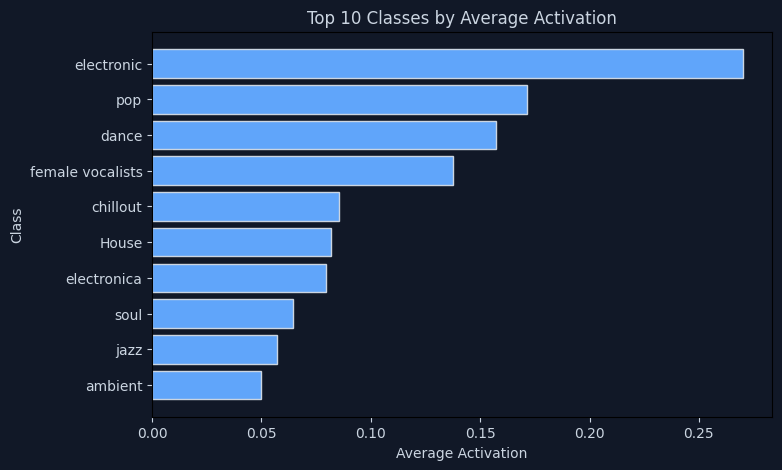

In [17]:
plot_top_10_classes(path_to_electronic_1, CLASSES)

(147, 50)


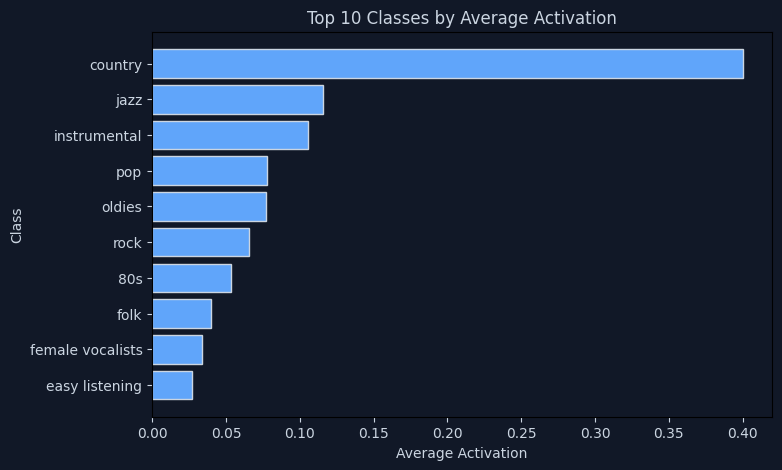

In [18]:
plot_top_10_classes(path_to_classical_1, CLASSES)    